# **Gender Equity at the Tokyo Olympics**

### In 2021, the International Olympic Committee (IOC) touted the Tokyo Games as the "[first gender-balanced Games in history](https://olympics.com/ioc/news/tokyo-2020-first-ever-gender-balanced-olympic-games-in-history-record-number-of-female-competitors-at-paralympic-games)" with women composing 49% of all athletes. The IOC was referring to the overall makeup of participants, but **I wondered whether or not this statement applied to competitors for specific teams and events.**

## **Scraping the data set**

> To start, I looked for information on the Olympics website. Of interest was the [medal count table](https://olympics.com/tokyo-2020/olympic-games/en/results/all-sports/medal-standings.htm), which contained each National Olympic Committee (NOC's) ranking based on the number of medals they had earned. Clicking on an NOC's name in the table opened a page with its event entries, including the number of male, female, and total athletes in each event.
>
> In order to scrape this data, I first ran through the medal count table to compile a list of links to the country-specific event pages.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [33]:
# Url of the page that we want to scrape
url = "https://olympics.com/tokyo-2020/olympic-games/en/results/all-sports/medal-standings.htm"

# Send a request to the server to retrieve the page's html
r = requests.get(url)

soup = BeautifulSoup(r.text, 'lxml')

In [34]:
# Isolate the main medal standing table
table = soup.find('table', id = 'medal-standing-table')

# Get the link to each country's page from the table
links = table.find_all('a', class_ = 'country')

In [ ]:
''' 
Result is a shortened file path such as "../../../en/results/all-sports/noc-entries-united-states.htm"
We need to restore the rest of the url through the following steps
'''

url_lib = []

for link in links:
    link_ending = link.get('href').strip("/.")
    new_link = "https://olympics.com/tokyo-2020/olympic-games/" + link_ending
    url_lib.append(new_link) 
    
# Now the complete url to each country's page is stored in url_lib

In [ ]:
# Store the names of all countries in a separate list for later use
country_names = [i.text.strip() for i in links]

> Next, I looped through the list of links to pull the information that I wanted from the country-specific event pages.

In [ ]:
# Based on inspection of the event entries table, we want to get this information
headings = ["Country", "Discipline", "Athletes_F", "Athletes_M", "Athletes_Total"]

# Create a Pandas dataframe with the above headings as columns
df = pd.DataFrame(columns = headings)

In [49]:
import time

# Scrape each country's page
for url in url_lib:
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    table = soup.find('table', class_ = 'table table-schedule')

    # Remember country's position in the list of urls
    idx = url_lib.index(url)

    # Loop through each discipline in which the country competed
    for tr in table.find_all('tr')[1:-2]: # Careful to exclude the footer row

        # Get the discipline name
        discipline = tr.find('th').text.strip()
        # Get the athlete breakdown for the discipline: female, male, and total
        athletes = tr.find_all('td')
        athletes = [i.text.strip() for i in athletes]

        # Combine these items into one list
        athletes.insert(0, discipline)

        # Assign country's name to the beginning of the list
        athletes.insert(0, country_names[idx])

        # Return number of rows already in data frame
        length = len(df)

        # Store the list as a new row
        df.loc[length] = athletes

    # Access the table footer 
    footer = table.find('tfoot').find('tr')

    # Get total size of the country's competing team
    totals = footer.find_all('td')
    totals = [i.text.strip() for i in totals]
    totals.insert(0, country_names[idx])

    length = len(df)
    df.loc[length] = totals

    # Delay next page request by 10 sec
    time.sleep(10)

In [4]:
# Export final dataframe as csv file
df.to_csv('olympicsdata.csv')

## **Notes**

> Before proceeding with this data set, here are two items to note:
>
> **1** - The medal standing table included the 93 NOCs that won at least one gold, silver, or bronze medal, but **it excluded the 119 NOCs who did not place in any event**. By gathering data for only countries that medaled, I assumed that the participation rates among their men and women could represent all competing athletes. I made this assumption because non-medaling countries often had teams of fewer than ten people, so they did not seem significant for the purpose of this analysis.
>
> **2** - The **countries in the table could be ranked in two ways**, either by total gold medals won or by total medals won overall. Both rankings were relatively consistent among the top countries, so I chose the former method for convenience. However, it would be interesting to see if the latter yields different results.

## **Exploratory analysis**

> After compiling my data, I used Matplotlib to build charts and visualize the relationship between various columns.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Import the csv file created previously
data = pd.read_csv('olympicsdata.csv')

# Remove extra index column
del data["Unnamed: 0"]

data.head()

,Country,Discipline,Athletes_F,Athletes_M,Athletes_Total
0,United States of America,3x3 Basketball,4,0,4
1,United States of America,Archery,3,3,6
2,United States of America,Artistic Gymnastics,6,5,11
3,United States of America,Artistic Swimming,2,0,2
4,United States of America,Athletics,65,63,128


### **Team size by country**
> I started with a basic bar chart to show each country's final medal standing along with their respective team size.

In [3]:
# Subset the data to rows containing each country's total team size (all disciplines combined)
totals = data[data["Discipline"] == "Total"]

totals.head()

,Country,Discipline,Athletes_F,Athletes_M,Athletes_Total
43,United States of America,Total,338,288,626
84,People's Republic of China,Total,288,125,413
130,Japan,Total,286,316,602
165,Great Britain,Total,205,178,383
203,ROC,Total,187,149,336


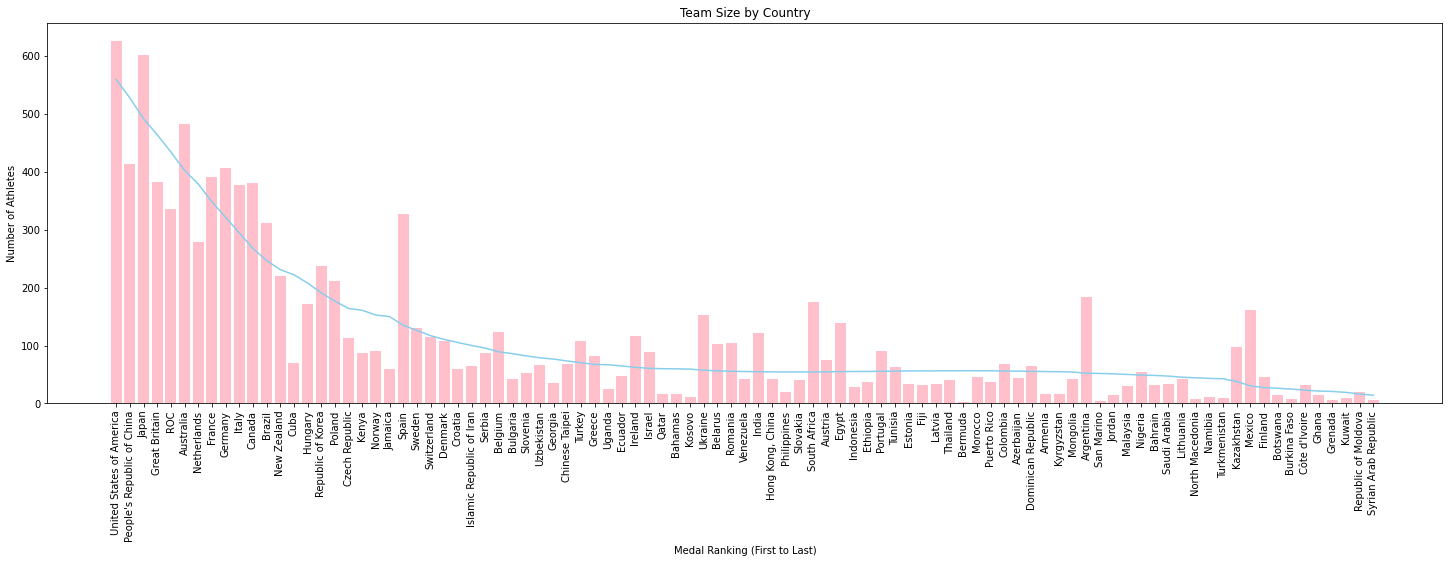

In [6]:
fig, axs = plt.subplots(figsize = (25,7))

# Plot a simple bar chart to display team size by country
plt.bar(totals["Country"], totals["Athletes_Total"], color="pink")

# Rotate x-axis labels from horizontal position to improve readability
plt.xticks(rotation=90)

# Label the plot
plt.title("Team Size by Country")
plt.xlabel("Medal Ranking (First to Last)")
plt.ylabel("Number of Athletes")

# Calculate a trend line with the following steps
import numpy as np

# May need to run this, if error: totals.reset_index(inplace=True)

# Convert columns from Pandas dataframe to Numpy array
country = totals["index"].to_numpy()
athletes = totals["Athletes_Total"].to_numpy()

# Fit a 4-degree polynomial to the data
z = np.polyfit(country, athletes, 4)
p = np.poly1d(z)

# Plot the trend line
plt.plot(totals["Country"], p(country), color="skyblue")

> In the bar chart above, the countries are ordered left to right by their medal standing. The United States, which placed 1st overall, had the largest team of over 600 athletes. China, which placed 2nd, had a team of around 420 athletes. Given the trendline, countries such as China, Russia (ROC), and Cuba seemd to have **performed better than expected** compared to other teams of their size. 

In [24]:
# Get correlation between country medal standing and team size, using Numpy
r = np.corrcoef(country, athletes)

r[0,1]

-0.7789659835244189

> The correlation coefficient, r = -0.78, suggests a **strong negative association between the medal standing of a country and its team size**. Unsurprisingly, countries that had smaller teams tended to rank lower (win fewer medals) while countries that had larger teams tended to rank higher (win more medals).

### **Gender composition by country**
> Next, I took a closer look at the breakdown of each country's athletes by gender.

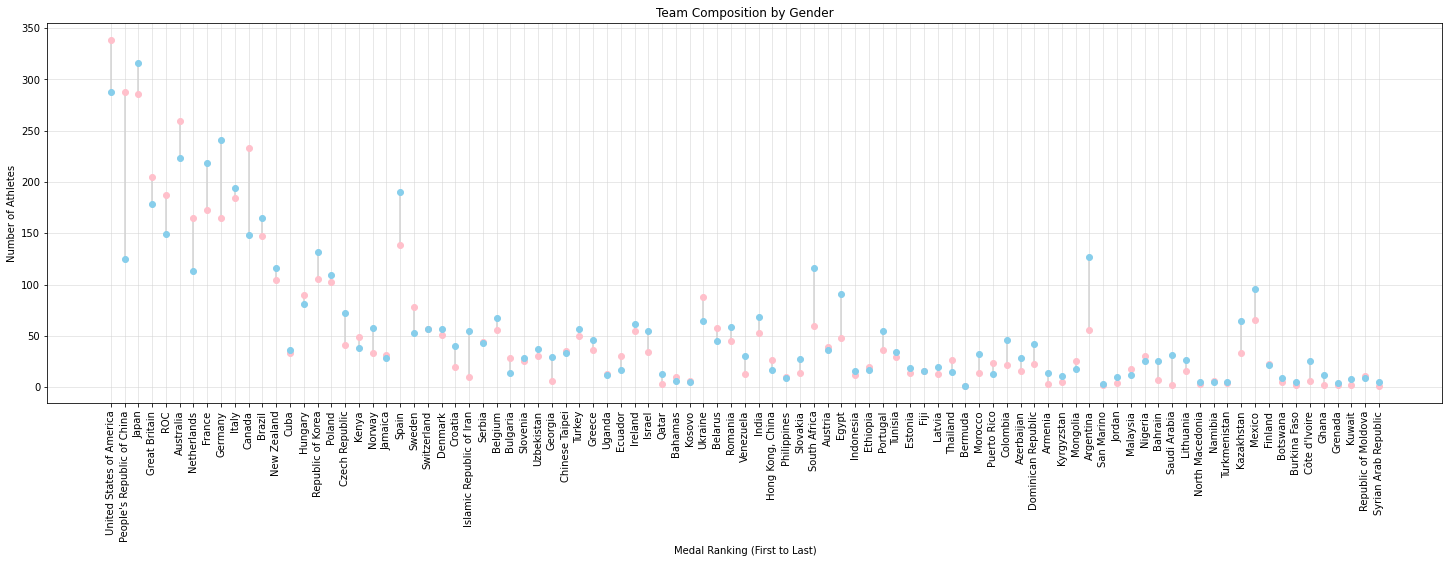

In [8]:
fig, axs = plt.subplots(figsize = (25,7))

# Create a dumbell chart with the following steps

# Plot dots for the number of male and female athletes competing on behalf of each country
axs.plot(totals['Country'], totals['Athletes_M'], marker="o", linewidth=0, color='skyblue')
axs.plot(totals['Country'], totals['Athletes_F'], marker="o", linewidth=0, color='pink')

# Before plotting the line chart, label each pair of dots
minimum = []
i = 0
while i < len(totals):
    # Store the smaller value in this list
    minimum.append(min(totals['Athletes_F'].iloc[i], totals['Athletes_M'].iloc[i]))
    i = i + 1
maximum = []
j = 0
while j < len(totals):
    # Store the larger value in this list
    maximum.append(max(totals['Athletes_F'].iloc[j], totals['Athletes_M'].iloc[j]))
    j = j + 1

# Now draw vertical lines from each smaller value to the larger value
plt.vlines(x=totals['Country'], ymin=minimum, ymax=maximum, color='lightgrey')

# Styling
plt.xticks(rotation=90)
plt.title("Team Composition by Gender")
plt.xlabel("Medal Ranking (First to Last)")
plt.ylabel("Number of Athletes")
plt.grid(color='lightgrey', linewidth=0.5)

plt.show()

> This dumbell chart shows that most countries had **unequal numbers of male and female athletes** on their teams. Notably, China had over twice (> 150) as many female competitors than male competitors. Canada, the Netherlands, and the United States also had female-leaning teams. On the other hand, countries like Germany, Spain, Argentina, and South Africa all had at least 50 more male athletes than female athletes.

### **Ratio of female to male athletes**
> We can picture this difference another way by plotting the ratio of women to men on each team.

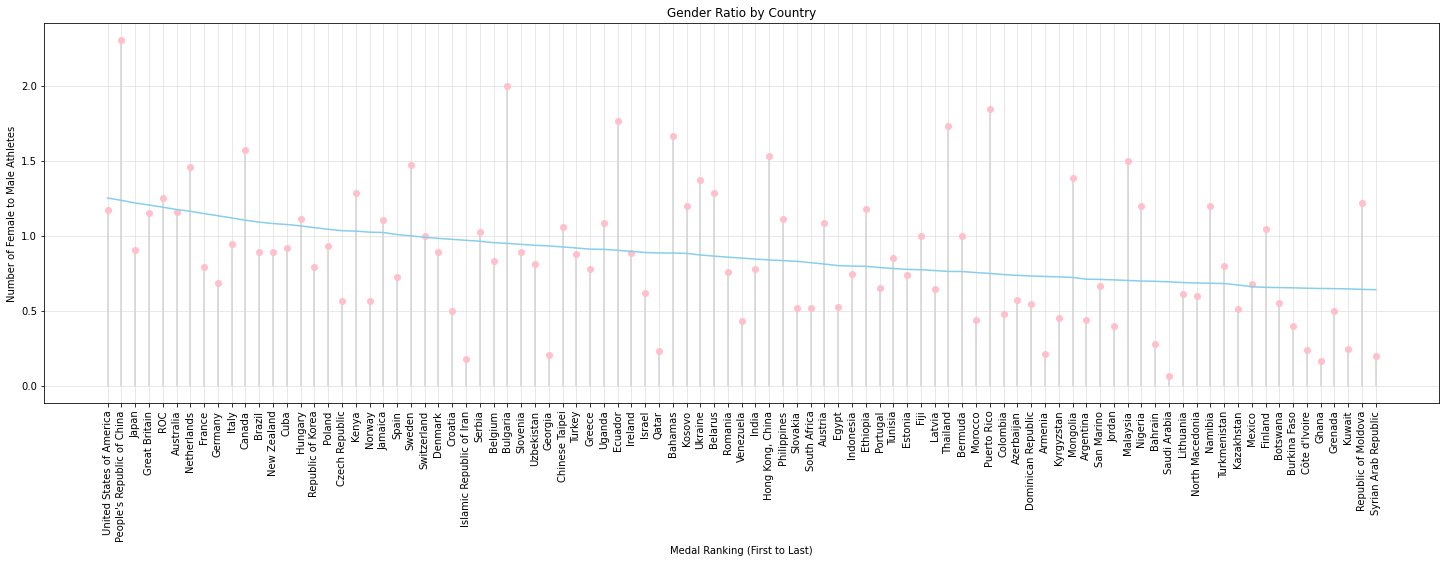

In [22]:
# Calculate the gender ratio for each country
ratio = []
i = 0
while i < len(totals):
    ratio.append(totals['Athletes_F'][i]/totals['Athletes_M'][i])
    i = i + 1
# Add column to dataframe
totals = totals.assign(Gender_Ratio = ratio)

# Create a lollipop chart
fig, axs = plt.subplots(figsize = (25,7))
axs.plot(totals['Country'], totals['Gender_Ratio'], marker="o", linewidth=0, color='pink')
plt.vlines(x=totals['Country'], ymin=0, ymax=totals['Gender_Ratio'], color='lightgrey')

# Styling
plt.xticks(rotation=90)
plt.title("Gender Ratio by Country")
plt.xlabel("Medal Ranking (First to Last)")
plt.ylabel("Number of Female to Male Athletes")
plt.grid(color='lightgrey', linewidth=0.5)

# Plot a trend line with the following steps

# Convert columns from Pandas dataframe to Numpy array
country = totals["index"].to_numpy()
ratio = totals["Gender_Ratio"].to_numpy()

# Fit a linear polynomial to the data
z = np.polyfit(country, athletes, 1)
p = np.poly1d(z)

# Plot the trend line
plt.plot(totals["Country"], p(country), color="skyblue")

> From the above chart, we can see the number of women to each man competing on a country's team. Again, China had the highest ratio with about 2.3 female athletes to every one male athlete. By contrast, Saudi Arabia had the lowest ratio of women to men. Female athletes composed just 6% of its team (2 out of 33 spots).
>
> Additionally, more than **60% of the countries pictured had fewer women than men** on their teams. Switzerland, Fiji, and Bermuda were the only participants with a 1:1 ratio of female to male athletes.

In [23]:
# Correlation between gender ratio and medal standing, using Pandas
r = totals["Gender_Ratio"].corr(totals["index"])
r

-0.3781563924055807

> The correlation coefficient, r = -0.38, suggests a **weak negative association between the medal standing of a country and its ratio of women to men**. Countries with a higher gender ratio (more women to each man) ranked higher while countries with a lower gender ratio (fewer women to each man) ranked lower. However, we can see instances where the opposite is true.

### **Gender composition by discipline**
> Finally, I wanted to visualize the gender composition of individual events (known as disciplines).

Text(0, 0.5, 'Number of Athletes')

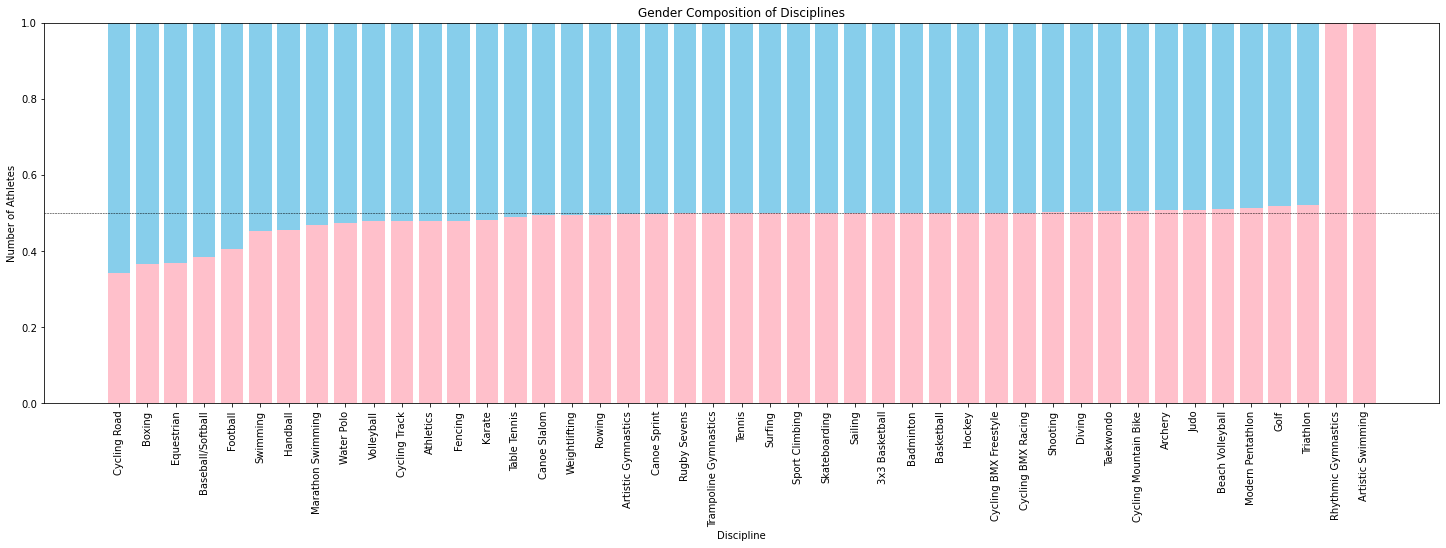

In [24]:
# Create a percentage stacked bar chart with the following steps

# Group rows by total athletes competing in each discipline
disciplines = data.groupby(["Discipline"]).sum()
disciplines.reset_index(inplace=True)
disciplines = disciplines.drop([40]) # Drop row labeled 'Totals'
disciplines.reset_index(inplace=True)

# Calculate percentage of each gender's participation
f = []
m = []
i = 0

while i < len(disciplines):
    f.append(disciplines['Athletes_F'][i]/disciplines['Athletes_Total'][i])
    m.append(disciplines['Athletes_M'][i]/disciplines['Athletes_Total'][i])
    i = i + 1
    
# Add columns to dataframe
disciplines = disciplines.assign(F_Ratio = f)
disciplines = disciplines.assign(M_Ratio = m)

# Sort values from low to high percentage of female athletes
disciplines = disciplines.sort_values('F_Ratio')

# Plot bar chart
fig, axs = plt.subplots(figsize = (25,7))
plt.bar(disciplines["Discipline"], disciplines["F_Ratio"], color="pink")
plt.bar(disciplines["Discipline"], disciplines["M_Ratio"], color="skyblue", bottom= disciplines["F_Ratio"])
axs.axhline(y=0.5, c="black", ls="--", lw="0.5")

# Styling
plt.xticks(rotation=90)
plt.title("Gender Composition of Disciplines")
plt.xlabel("Discipline")
plt.ylabel("Number of Athletes")

> This bar chart reveals that events such as rowing, tennis, and basketball hosted equal numbers of men and women athletes. However, several events were skewed in composition toward one gender or the other. 

> To the right, we see that artistic swimming and rythmic gymnastics are the **only all-female events**. Although men have performed in both sports at the national level, the IOC [doesn't provide a way](https://www.bbc.com/news/magazine-33566335) for them to compete at the highest level at the Olympics. Unfortunately, there is [insufficient interest](https://apnews.com/article/2020-tokyo-olympics-gymnastics-entertainment-sports-lifestyle-abeb9ae89ceccd0f95728c07846310e6) and participation among men to justify versions of these events for males. In many countries, the sports are percieved as "feminine" despite the impressive strength and agility required from their respective athletes.
>
> To the left, we see that the **male road cycling event featured 31% more competitors** than its female counterpart. Historically, cycling has faced [critism](https://www.thestar.com/sports/olympics/opinion/2021/07/21/cycling-is-rolling-slowly-toward-gender-equity-too-slowly-for-its-critics.html) for its lack of progress toward gender equity. In the 1996 Atlanta Games, 58 women competed as compared to 183 men. This large gap remains with just 67 women competing this year as compared to 130 men. The length of the women's race is also shorter than the men's race, stretching 137 kilometers compared to the latter's 234 kilometers. 

> Similar gender disparities exist among other Olympic events like boxing, equestrian, softball, football, and swimming.

# **Conclusion**

### As a whole, women may have gained ground at the Games, but gender inequity is still present on an event and country level. This difference not only manifests in the data but also in the IOC's  rules, which have raised questions about the true status of women athletes at the Olympics. Just this year, the Norwegian women's handball team was [fined](https://www.nbcnews.com/news/sports/norwegian-women-s-beach-handball-team-fined-not-playing-bikinis-n1274453) after choosing to compete in shorts rather than bikini bottoms. That being said, public support for their move along with growing scrutiny of the IOC itself offers hope for the future.

### **What's next?** I would like to revisit this project during subsequent Olympics and to compare the progress toward gender equity between the summer and winter Games.
